## Computer Vision - Licence Plate Detection and Recognition

### 0. Setup

In this notebook, we will implement a system for detecting and recognizing license plates from images using computer vision techniques.

- The requirement are register in the requirements.txt file.
- To install them, run the following command:
  
  ```bash
  pip install -r requirements.txt
  ```


"We provide the trained model weights in the 'models' directory. You can load these weights into your model for inference or further training."


### 1. Importing Libraries and Defining Helper Functions

In [7]:
import os
import cv2
import yaml
import shutil
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from PIL import Image
import torch
import sys
# print(torch.cuda.is_available())

from ultralytics import YOLO
sys.path.append("../src")

from utils import pair_split, display_image_with_bboxes, plot_yolo_sample

### 2. Loading Dataset and Preprocessing

#### 2.0 Define path variables

In [8]:
image_dir = "../data/images"
label_dir = "../data/labels"

#### 2.1 Define a function to pair images and labels

In [9]:
train_pairs = pair_split(image_dir+"/train", label_dir+"/train")
val_pairs   = pair_split(image_dir+"/val", label_dir+"/val")
test_pairs  = pair_split(image_dir+"/test", label_dir+"/test")

In [33]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

25470
1073
386


#### 2.2 Convert into normalized dataset

In [10]:
import os
from PIL import Image

def process_pairs_to_normalized_dataset(pairs):
    dataset_list = []

    for img_path, label_path in pairs:
        # Charger l'image
        try:
            img_pil = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            continue

        bboxes = []
        class_ids = []

        # Lire le fichier label YOLO (format: class xc yc w h)
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    
                    c, xc, yc, w, h = map(float, parts)
                    
                    # On garde les valeurs telles quelles (normalisées)
                    bboxes.append([xc, yc, w, h])
                    class_ids.append(int(c))
        
        dataset_list.append((img_pil, bboxes, class_ids))

    return dataset_list



In [34]:
train_dataset = process_pairs_to_normalized_dataset(train_pairs[:1500])
val_dataset   = process_pairs_to_normalized_dataset(val_pairs[:200])

KeyboardInterrupt: 

#### 2.3 Transorm into PyTorch Dataset (YOLO format)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class YoloDataset(Dataset):
    def __init__(self, dataset_source, transform, S=7):
        self.dataset = dataset_source
        self.transform = transform
        self.S = S
        self.num_classes = 1 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, bboxes, class_ids = self.dataset[idx]
        img = self.transform(img)

        # Matrice YOLO : [x, y, w, h, confidence, class_0]
        label_matrix = torch.zeros((self.S, self.S, 6))

        for bbox in bboxes:
            xc, yc, w, h = bbox
            
            # Indexation de la grille
            j = min(int(xc * self.S), self.S - 1)
            i = min(int(yc * self.S), self.S - 1)

            # Si la cellule est vide, on y place l'objet
            if label_matrix[i, j, 4] == 0:
                # Coordonnées relatives à la cellule
                x_cell = xc * self.S - j
                y_cell = yc * self.S - i

                label_matrix[i, j, 0:4] = torch.tensor([x_cell, y_cell, w, h])
                label_matrix[i, j, 4] = 1.0  # Confiance
                label_matrix[i, j, 5] = 1.0  # Classe plaque
                
        return img, label_matrix

In [13]:
import torchvision.transforms as transforms

# Définissez une taille standard (YOLO utilise souvent 416 ou 640)
IMAGE_SIZE = 416 

my_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Redimensionne TOUTES les images
    transforms.ToTensor(),                        # Convertit en [0, 1]
])

# Appliquez ces transformations à vos datasets
train_ds = YoloDataset(train_dataset, transform=my_transforms, S=13)
val_ds   = YoloDataset(val_dataset,   transform=my_transforms, S=13)

#### 2.4 Visualizing an example from the dataset

Image tensor shape: torch.Size([3, 416, 416])
Label matrix shape: torch.Size([13, 13, 6])


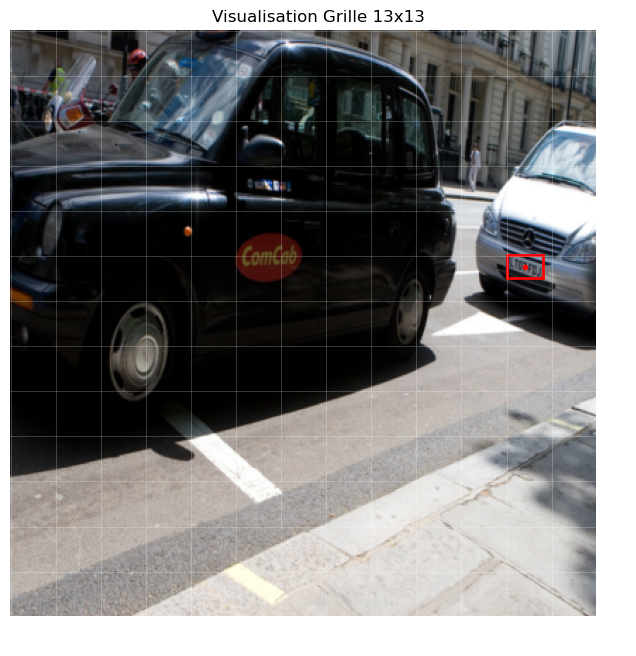

In [20]:
img, label = train_ds[13] 
print("Image tensor shape:", img.shape)
print("Label matrix shape:", label.shape)
plot_yolo_sample(img, label, S=13)

In [22]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

### 3. Model Definition

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YOLOv1(nn.Module):
    def __init__(self, S=3, C=1):
        super().__init__()
        self.S = S
        self.C = C
        self.out_channels = 5 + C  # (x,y,w,h,obj) + classes

        # ------------------- -------
        # YOLOv1 Backbone (Deep)
        # --------------------------
        self.features = nn.Sequential(
            # --------- Layer Group 1 ---------
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Group 2 ---------
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Group 3 ---------
            nn.Conv2d(192, 128, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- 4× Repeated Block ---------
            *[
                nn.Sequential(
                    nn.Conv2d(512, 256, kernel_size=1),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(256, 512, kernel_size=3, padding=1),
                    nn.LeakyReLU(0.1)
                ) for _ in range(4)
            ],

            nn.Conv2d(512, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Final Block ---------
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )

        # --------------------------
        # YOLOv1 Head (Simplified)
        # --------------------------
        self.pred_head = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, self.out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)          # TO DO
        x = self.pred_head(x)         # TO DO
        x = x.permute(0, 2, 3, 1) 
        print(x.shape)    # TO DO
        return x


In [24]:
test = YOLOv1(S=7, C=1)
print(test)

YOLOv1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Sequential(
      (0): Conv2d(512, 256,

In [25]:
from torchinfo import summary
summary(test, input_size=(3,3, 768, 1024))

torch.Size([3, 24, 32, 6])


Layer (type:depth-idx)                   Output Shape              Param #
YOLOv1                                   [3, 24, 32, 6]            --
├─Sequential: 1-1                        [3, 1024, 24, 32]         --
│    └─Conv2d: 2-1                       [3, 64, 384, 512]         9,472
│    └─LeakyReLU: 2-2                    [3, 64, 384, 512]         --
│    └─MaxPool2d: 2-3                    [3, 64, 192, 256]         --
│    └─Conv2d: 2-4                       [3, 192, 192, 256]        110,784
│    └─LeakyReLU: 2-5                    [3, 192, 192, 256]        --
│    └─MaxPool2d: 2-6                    [3, 192, 96, 128]         --
│    └─Conv2d: 2-7                       [3, 128, 96, 128]         24,704
│    └─LeakyReLU: 2-8                    [3, 128, 96, 128]         --
│    └─Conv2d: 2-9                       [3, 256, 96, 128]         295,168
│    └─LeakyReLU: 2-10                   [3, 256, 96, 128]         --
│    └─Conv2d: 2-11                      [3, 256, 96, 128]         6

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv1(S=13, C=1).to(device)

bbox_loss_fn = nn.MSELoss() 
cls_loss_fn = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
acc_history = []


### 4. Training and Evaluation

In [27]:
def yolo_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):

    obj_mask    = target[..., 4] == 1      # mask for grid cells that contain an object
    noobj_mask  = target[..., 4] == 0      # mask for grid cells without an object

    # 1) COORDINATE LOSS ----------------------------------------------------
    loss_xywh = ((pred[...,0:4] - target[...,0:4])**2)[obj_mask].sum()        # L2 loss on (x,y,w,h) only where an object exists

    # 2) OBJECTNESS LOSS ----------------------------------------------------
    obj_pred = torch.sigmoid(pred[...,4])  # apply sigmoid to objectness score

    loss_obj = nn.functional.binary_cross_entropy(obj_pred[obj_mask], target[...,4][obj_mask])         # BCE loss for object cells (want confidence=1)
    loss_noobj = nn.functional.binary_cross_entropy(obj_pred[noobj_mask], target[...,4][noobj_mask])   # BCE loss for no-object cells (want confidence=0)

    # 3) CLASSIFICATION LOSS ------------------------------------------------
    pred_cls = pred[..., 5:]               # predicted class logits
    target_cls = target[..., 5:]           # ground-truth one-hot class labels

    cls_pred = pred_cls[obj_mask]          # keep class logits only for object cells
    cls_true = target_cls[obj_mask]        # keep corresponding GT labels

    if cls_pred.numel() > 0:               # check if there are any object cells
        cls_true = cls_true.argmax(-1)     # convert one-hot labels to class indices
        loss_cls = nn.functional.cross_entropy(cls_pred, cls_true)   # cross-entropy classification loss
    else:
        loss_cls = torch.tensor(0.0, device=pred.device)             # no objects → class loss = 0

    # FINAL LOSS ------------------------------------------------------------
    return (lambda_coord * loss_xywh       # weighted coordinate loss
            + loss_obj                     # objectness loss for object cells
            + lambda_noobj * loss_noobj    # downweighted no-object loss
            + loss_cls)                    # classification loss


In [28]:
def yolo_accuracy(pred, target):
    """
    Computes classification accuracy ONLY for cells containing objects.
    pred: (B,S,S,5+C)
    target: (B,S,S,5+C)
    """
    obj_mask = target[..., 4] == 1  # cells with objects

    if obj_mask.sum() == 0:
        return 0.0

    pred_cls = pred[..., 5:].argmax(-1)     # predicted class index
    true_cls = target[..., 5:].argmax(-1)   # true class index

    correct = (pred_cls[obj_mask] == true_cls[obj_mask]).sum().item()
    total = obj_mask.sum().item()

    return correct / total


In [29]:
model = YOLOv1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_history = []
acc_history = []

for epoch in range(5):
    total_loss = 0
    total_acc  = 0
    total_batches = 0

    for imgs, labels in train_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss  = yolo_loss(preds, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    avg_loss = total_loss / total_batches


    loss_history.append(avg_loss)


    print(f"Epoch {epoch+1}: Loss={avg_loss:.3f}")


torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])


KeyboardInterrupt: 

### 5. Reading Parts

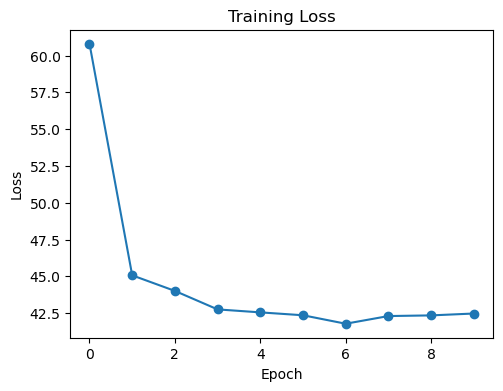

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(loss_history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


In [56]:
def iou(box1, box2):
    # box format: x_center, y_center, w, h (normalized 0–1)
    x1, y1, w1, h1 = box1                     # unpack first box
    x2, y2, w2, h2 = box2                     # unpack second box

    # convert YOLO center format → corner format (x_min, y_min, x_max, y_max)
    x1a, y1a = x1 - w1/2, y1 - h1/2            # top-left corner of box1
    x1b, y1b = x1 + w1/2, y1 + h1/2            # bottom-right corner of box1

    x2a, y2a = x2 - w2/2, y2 - h2/2            # top-left of box2
    x2b, y2b = x2 + w2/2, y2 + h2/2            # bottom-right of box2

    # compute intersection rectangle
    xi1 = max(x1a, x2a)                        # intersection top-left x
    yi1 = max(y1a, y2a)                        # intersection top-left y
    xi2 = min(x1b, x2b)                        # intersection bottom-right x
    yi2 = min(y1b, y2b)                        # intersection bottom-right y

    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)  # intersection area

    area1 = w1 * h1                            # area of box1
    area2 = w2 * h2                            # area of box2

    return inter / (area1 + area2 - inter + 1e-6)  # IoU formula with epsilon


def nms(boxes, scores, thresh=0.5):
    """
    boxes: Tensor or list of [x,y,w,h]
    scores: Tensor of shape [N]
    """
    # Ensure input is a Python list
    if isinstance(boxes, torch.Tensor):
        boxes_list = boxes.tolist()            # convert tensor → list
    else:
        boxes_list = boxes                     # already a list

    idxs = scores.argsort(descending=True)     # sort indices by confidence
    keep = []                                  # list of selected boxes

    while len(idxs) > 0:                       # until no boxes left
        k = idxs[0].item()                     # box with highest score
        keep.append(k)                         # keep this box

        new_indices = []                       # indices to retain
        for i in idxs[1:]:                     # compare with remaining boxes
            i = i.item()                       # convert tensor index → int
            if iou(boxes_list[k], boxes_list[i]) < thresh:
                new_indices.append(i)          # keep boxes with low overlap

        idxs = torch.tensor(new_indices, dtype=torch.long)  # update list

    return torch.tensor(keep, dtype=torch.long) # return final selected indices


torch.Size([1, 13, 13, 6])
torch.Size([1, 13, 13, 6])
torch.Size([1, 13, 13, 6])
torch.Size([1, 13, 13, 6])


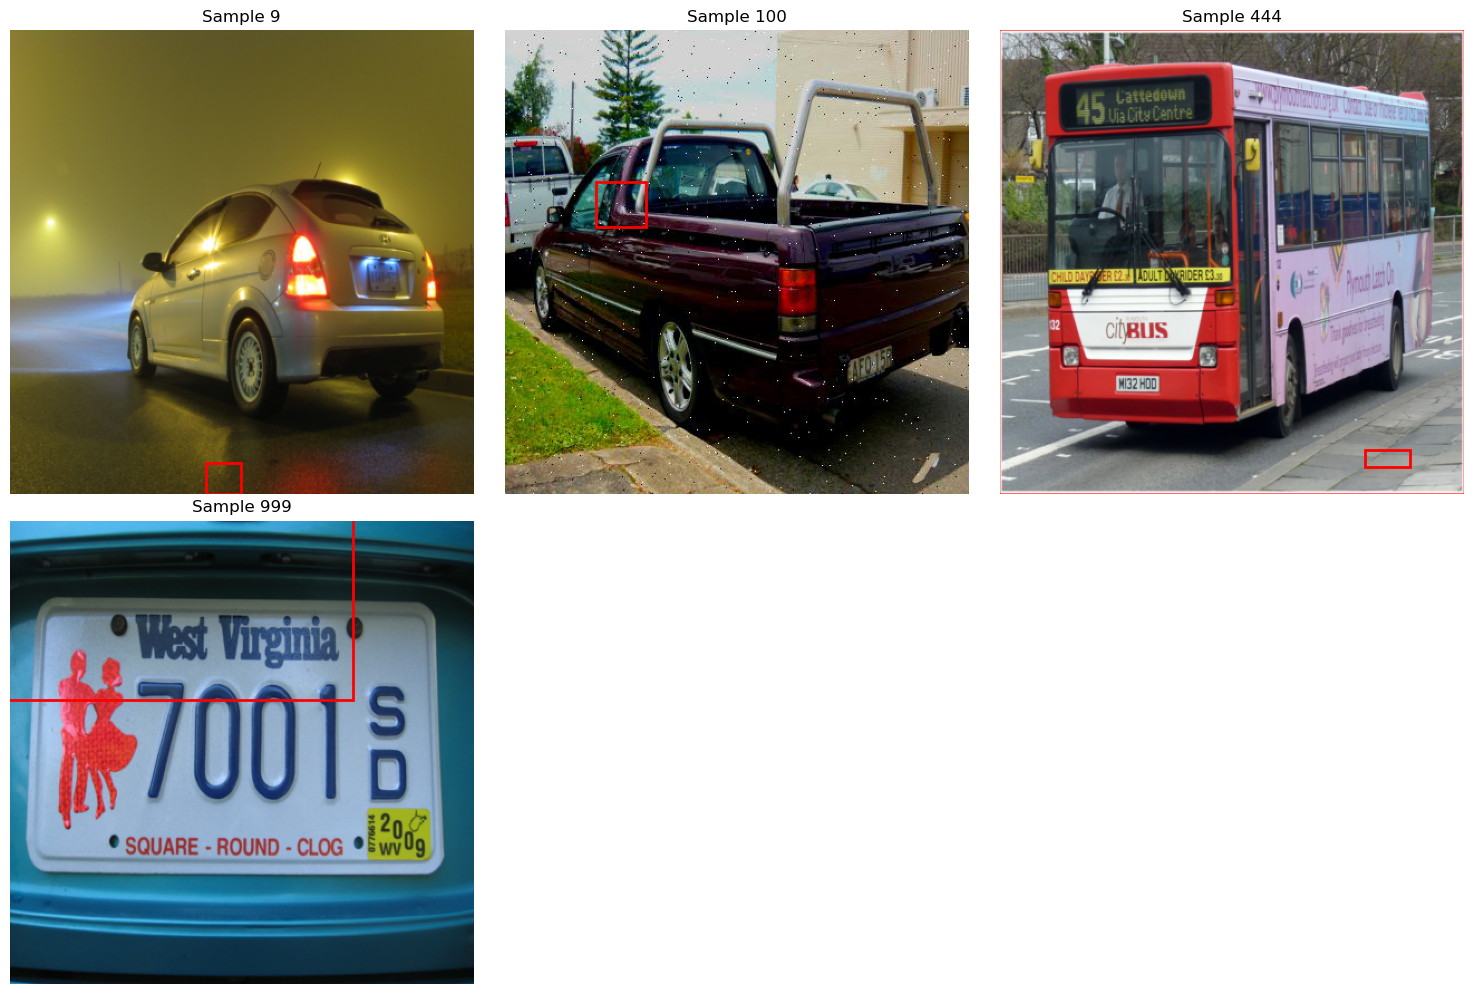

In [60]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ===============================
# Utility: YOLO normalized → corners
# ===============================
def yolo_to_corners(box, W, H):
    x, y, w, h = box
    x *= W;   y *= H
    w *= W;   h *= H
    x0 = x - w/2
    y0 = y - h/2
    return x0, y0, w, h


# ===============================
# Decode YOLO output
# ===============================
def get_predictions(pred, S=13, conf_thresh=0.3):
    pred = pred.detach().cpu()
    C = pred.shape[-1] - 5

    boxes, scores, classes = [], [], []

    for i in range(S):
        for j in range(S):
            cell = pred[i, j]

            obj = torch.sigmoid(cell[4]).item()
            if obj < conf_thresh:
                continue

            class_logits = cell[5:]
            cls = torch.argmax(class_logits).item()
            class_conf = torch.softmax(class_logits, dim=0)[cls].item()

            score = obj * class_conf

            px, py, pw, ph = cell[:4]
            x = (j + px) / S
            y = (i + py) / S
            w = pw
            h = ph

            boxes.append([x, y, w, h])
            scores.append(score)
            classes.append(cls)

    if len(boxes) == 0:
        return [], [], []

    boxes = torch.tensor(boxes, dtype=torch.float32)
    scores = torch.tensor(scores)
    classes = torch.tensor(classes)

    keep = nms(boxes, scores, 0.2)

    return boxes[keep], classes[keep], scores[keep]


# ===============================
# Extract ground-truth boxes from label
# ===============================
def get_ground_truth_boxes(target, S=3):
    obj_mask = target[...,4] == 1
    if obj_mask.sum() == 0:
        return [], []

    boxes = target[...,0:4][obj_mask]
    classes = target[...,5:].argmax(-1)[obj_mask]

    return boxes.cpu().tolist(), classes.cpu().tolist()


# ===============================
# Draw image with GT + predictions
# ===============================
def draw_detections(img_tensor, pred_boxes, pred_classes, pred_scores, gt_boxes, gt_classes):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    H, W, _ = img.shape

    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.imshow(img)
    ax.axis("off")

    # GT (RED)
    for box, cls in zip(gt_boxes, gt_classes):
        x0, y0, w, h = yolo_to_corners(box, W, H)
        rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0-2, f"GT: {id_to_name[cls]}", color="red", fontsize=10, backgroundcolor="white")

    # Predictions (LIME)
    for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
        x0, y0, w, h = yolo_to_corners(box.tolist(), W, H)
        rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0-2, f"{id_to_name[cls.item()]} {score:.2f}",
                color="lime", fontsize=10, backgroundcolor="black")

    plt.show()


# ===============================
# FINAL FUNCTION: SHOW GT + PREDICTIONS
# ===============================
def show_batch_detections(indices, cols=3, conf_thresh=0.3):
    """
    indices: list of dataset indices to visualize
    cols: number of columns in the grid
    """
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = train_ds[idx]
        inp = img.unsqueeze(0).to(device)

        # prediction
        with torch.no_grad():
            pred = model(inp)[0]

        pred_boxes, pred_classes, pred_scores = get_predictions(pred, S=13, conf_thresh=conf_thresh)
        gt_boxes, gt_classes = get_ground_truth_boxes(target)

        # prepare image
        W = img.shape[2]
        H = img.shape[1]
        ax.imshow(img.permute(1,2,0).cpu().numpy())
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

        # Draw GT (RED)
        for box, cls in zip(gt_boxes, gt_classes):
            x0, y0, w, h = yolo_to_corners(box, W, H)
            rect = patches.Rectangle((x0, y0), w, h, edgecolor="red", facecolor="none", linewidth=2)
            ax.add_patch(rect)
            # ax.text(x0, y0-2, f"GT:{id_to_name[cls]}", color="red", fontsize=8, backgroundcolor="white")

        # Draw predictions (LIME)
        for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
            x0, y0, w, h = yolo_to_corners(box.tolist(), W, H)
            rect = patches.Rectangle((x0, y0), w, h, edgecolor="lime", facecolor="none", linewidth=2)
            # ax.add_patch(rect)
            # ax.text(x0, y0-2, f"{id_to_name[cls.item()]} {score:.2f}",
            #         color="lime", fontsize=8, backgroundcolor="black")

    # Hide unused axes
    for ax in axes[len(indices):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ===============================
# TEST ON IMAGEs
# ===============================
show_batch_detections([9,100,444,999])

